In [1]:
#imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_predict,
                                     cross_validate, train_test_split)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import statistics
import shap
from sksurv.ensemble import RandomSurvivalForest
from lifelines import KaplanMeierFitter


random_state = 42

In [2]:
#ds loading and variables removal 
ds = pd.read_csv(r"C:\Users\USER\OneDrive\Summer_project\Azure\annex study\ds_annex_study.csv", index_col = 'ID')
ds = ds.drop(columns=['date','DOB', 'preexisting_cond', 'twoyears', 'fiveyears', 'death'])

In [3]:
#Extra preprocessing (1-hot encoding)
ds = ds.fillna(ds.mean())
ds = ds.fillna(0)


for variable in ['COPD', 'ILD', 'NTM']:
    ds[variable][ds[variable] == 'Yes'] = 1
    ds[variable][ds[variable] == 'No'] = 0

ds['sex'][ds['sex'] == 'F'] = 0
ds['sex'][ds['sex'] == 'M'] = 1

ds.ethnicity = ds.ethnicity.astype('category').cat.codes

labels2 = ds['dead2']
labels5 = ds['dead5']

ds = ds.drop(columns = ['dead2'])

counter2 = Counter(labels2)
counter5 = Counter(labels5)

print('2 years', counter2)
print('5 years', counter5)

counter = counter5

# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
estimate2 = counter[1]/counter[0]

#dataset split 
X_train, X_test, y_train, y_test = train_test_split(ds, labels2, test_size=0.2, shuffle = True, random_state=random_state)
features = ds.columns
# ds = np.array(ds)
# labels2 = np.array(labels2)


2 years Counter({0: 61, 1: 24})
5 years Counter({0: 46, 1: 39})


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [4]:
SHAP = True

# model = RandomForestClassifier(random_state=random_state, class_weight = {0:estimate2, 1:estimate})
# model = XGBClassifier(random_state=random_state, scale_pos_weight = estimate)
# model = XGBClassifier(random_state=random_state, scale_pos_weight = estimate)
model = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
# model = LogisticRegression(random_state = random_state)
labels = labels5

#model training
skf = KFold(n_splits=5, random_state=random_state, shuffle=True)
acc = []
cms = []
f1 = []

for train_index, test_index in skf.split(ds, labels):
    X_train, X_test = ds[train_index], ds[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print(X_test)
    xgbc = model
    xgbc.fit(X_train, y_train)
    y_pred = xgbc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cf = confusion_matrix(y_test, y_pred)
    fscore = f1_score(y_test, y_pred)
    acc.append(accuracy)
    cms.append(cf)
    f1.append(fscore)
    print('Accuracy:', round(accuracy,2))
    print('F1-score:', round(fscore,2))
    print('Confusion matrix:\n', cf)

    if SHAP:
        ex = shap.Explainer(model)
        shaps_values = ex.shap_values(X_test)
        plt.figure(figsize = (15,15))
        shap.summary_plot(shaps_values, pd.DataFrame(X_test.astype('float'), columns = features), show = True)
        plt.savefig('SHAP_CPA.png',bbox_inches='tight', dpi=300)
        SHAP = False

print('Averaged accuracy (5-folds): %.3f ±  %.3f' % (np.mean(acc), statistics.stdev(acc)))
print('Averaged f1-score (5-folds): %.3f ±  %.3f' % (np.mean(f1), statistics.stdev(f1)))



KeyError: "None of [Int64Index([ 1,  2,  3,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 19, 20, 21,\n            23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 39, 41, 42,\n            43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62,\n            63, 64, 65, 67, 69, 70, 71, 73, 74, 75, 76, 77, 79, 80, 81, 83,\n            84],\n           dtype='int64')] are in the [columns]"

              COPD
timeline          
0.0       0.000000
16.0      0.047619
23.0      0.095238
84.0      0.142857
305.0     0.190476
343.0     0.238095
1016.0    0.285714
1144.0    0.285714
1258.0    0.285714
1305.0    0.285714
1312.0    0.345238
1422.0    0.345238
1455.0    0.410714
1508.0    0.410714
1510.0    0.410714
1524.0    0.494898
1540.0    0.579082
1558.0    0.579082
1703.0    0.579082
1731.0    0.579082
2085.0    0.579082
2157.0    0.579082
           No COPD
timeline          
0.0       0.000000
13.0      0.015625
37.0      0.031250
48.0      0.046875
67.0      0.062500
...            ...
2977.0    0.484508
3077.0    0.484508
3519.0    0.484508
3587.0    0.484508
3881.0    0.484508

[65 rows x 1 columns]


<AxesSubplot:title={'center':'KMF'}, xlabel='timeline', ylabel='Survival'>

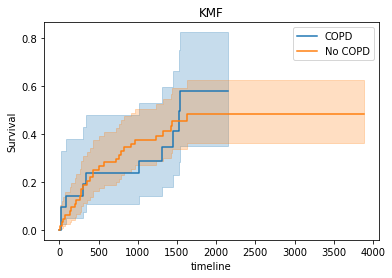

In [5]:
###COPD 

kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('COPD == 1')
neg = ds.query('COPD == 0')

kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="COPD")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="No COPD")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))

# print (kmf_1.survival_function_)
# print (kmf_0.survival_function_)

# Plot the survival_function data :
# kmf_1.plot()
# kmf_0.plot()
plt.xlabel("Days passed")
plt.ylabel("Survival")
plt.title("KMF")


print (kmf_1.cumulative_density_)
print (kmf_0.cumulative_density_)

kmf_1.plot_cumulative_density()
kmf_0.plot_cumulative_density()



['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


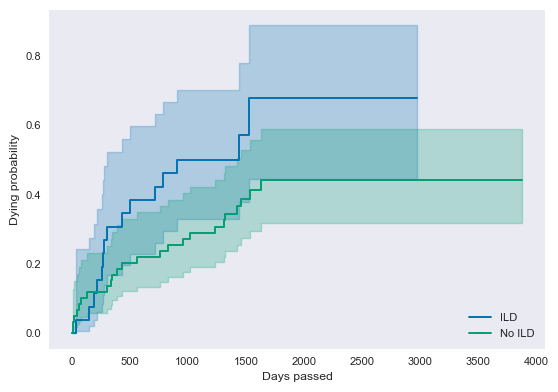

In [36]:
###ILD 
print(plt.style.available)
plt.rcdefaults() 
plt.style.use(['seaborn-paper', 'seaborn-dark', 'seaborn-colorblind'])

kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('ILD == 1')
neg = ds.query('ILD == 0')

kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="ILD")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="No ILD")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))

# print (kmf_1.survival_function_)
# print (kmf_0.survival_function_)

# Plot the survival_function data :
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



kmf_1.plot_cumulative_density()
kmf_0.plot_cumulative_density()
plt.xlabel("Days passed")
plt.ylabel("Dying probability")
legend = ax.legend(loc='lower right')
ax.grid(False)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


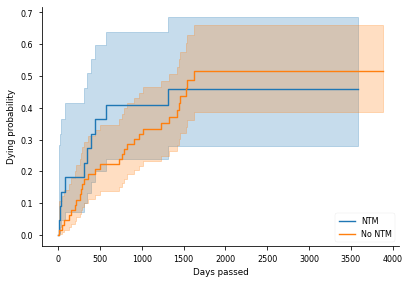

In [8]:
###NTM 
print(plt.style.available)
plt.style.use('seaborn-paper')
kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('NTM == 1')
neg = ds.query('NTM == 0')

kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="NTM")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="No NTM")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))

# print (kmf_1.survival_function_)
# print (kmf_0.survival_function_)

# Plot the survival_function data :
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.title("KMF")

kmf_1.plot_cumulative_density()
kmf_0.plot_cumulative_density()
plt.xlabel("Days passed")
plt.ylabel("Dying probability")
legend = ax.legend(loc='lower right')
ax.grid(False)


In [ ]:
#COX hazard model with or without CT scan data 
